In [2]:
num_trials = 8
using SharedArrays
using Distributed
addprocs(num_trials)

@everywhere using PyCall
@everywhere using Random

In [ ]:
@everywhere include("seajul.jl")
@time begin

epochs = 200
T = Float64

env_name = "InvertedPendulum-v2"
gym = pyimport("gym")
pyimport("pybullet_envs")
env = gym.make(env_name)
in_size = env.observation_space.shape[1]
out_size = env.action_space.shape[1]
 
Wa = SharedArray{T}(num_trials, out_size, in_size)
ra = SharedArray{T}(num_trials, epochs)

for i in 1:num_trials
    seed = rand(1:2^16)
    Random.seed!(seed)
    gym = pyimport("gym")
    pyimport("pybullet_envs")
    env = gym.make(env_name)

    W = randn(T, out_size, in_size)
    #W,rews,μ,sig = SJ.ars_v2t!(env,W,epochs,T=T)
    W,rews = SJ.ars_v1t_dis!(env,W,epochs)

    Wa[i,:,:] = W 
    ra[i,:] = rews

end
end

In [ ]:
using Plots

plot()
for i in 1:num_trials
    plot!(ra[i,:])
end
plot!()

In [6]:
function do_rollout_eval(env::PyObject, W)
    x = env.reset()
    done = false
    reward = 0.0

    x_hist = zeros(env.observation_space.shape[1],env._max_episode_steps)
    i = 1

    act_low = convert(Array{Float64,1}, env.action_space.low)
    act_high = convert(Array{Float64,1}, env.action_space.high)

    while !done
        x_hist[:,i] = copy(x); i+=1
        u = clamp(W*x, act_low, act_high)
        x, r, done, _ = env.step(u)
        reward += r
    end
    #println(vec(mean(x_hist[:,1:i-1],dims=2)))
    return reward::Float64, x_hist
end


do_rollout_eval (generic function with 1 method)

In [ ]:
Wa[1,:,:] = W
r,x = do_rollout_eval(env,W)

In [ ]:
function f(arr, T)
    a = Array{T,5}
    for i in  1:5
        a[1] = sum(arr)
    end

    return a

end

In [ ]:
@code_llvm f(zeros(4,4), Float32)

In [ ]:

#function invertedPendDynamics(o,a)
#    """ inverted pendulum 
#        o = [θ, ̇dθ]
#    """
#    return [o[2],(a + cos(o[1]) + m*l)/m*l^2]
#end

In [ ]:
@everywhere include("seajul.jl")
using .SJ
env = SJ.PendEnv(1,1,100)
X,R = SJ.do_rollout_eval(env, (x)->0.0)

In [ ]:
plot(X)

In [58]:
@everywhere include("seajul.jl")
@time begin

epochs = 200
T = Float64


Wa = SharedArray{T}(num_trials, 1, 2)
ra = SharedArray{T}(num_trials, epochs)

for i in 1:num_trials
    seed = rand(1:2^16)
    Random.seed!(seed)
    env = SJ.PendEnv(1,1,1000)
    W = randn(T, 1, 2)
    #W = Wa[i,:,:]

        
    #W,rews,μ,sig = SJ.ars_v2t!(env,W,epochs,T=T)
    W,rews = SJ.ars_v1t!(env,W,epochs)

    Wa[i,:,:] = W 
    ra[i,:] = rews

end
end

      From worker 3:	WARNING: replacing module SJ.
      From worker 9:	WARNING: replacing module SJ.
      From worker 7:	WARNING: replacing module SJ.
      From worker 5:	WARNING: replacing module SJ.
      From worker 2:	WARNING: replacing module SJ.
      From worker 4:	WARNING: replacing module SJ.
      From worker 6:	WARNING: replacing module SJ.
      From worker 8:	WARNING: replacing module SJ.
115.678236 seconds (2.77 G allocations: 201.467 GiB, 25.98% gc time)


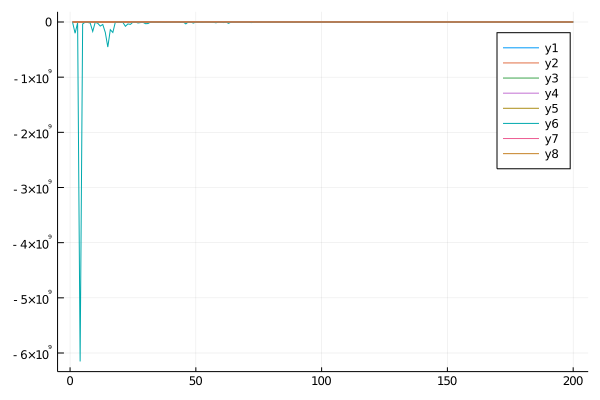

In [60]:
using Plots

plot()
for i in 1:num_trials
    plot!(ra[i,:])
end
plot!()

In [61]:
env = SJ.PendEnv(1,1,1000)
X,A,R = SJ.do_rollout_eval(env, (x)->Wa[2,:,:]*x)

([-0.3947136349403308 -1.1275714314086818; -0.4055347279754929 -1.0367160254514702; … ; -9.944181849499072 18.231308414765216; -9.761518008905067 18.30022295473741], [0.020071183234318835; 0.05994999428670533; … ; 15.957049671644283; 15.794559625657804], -144282.361731996)

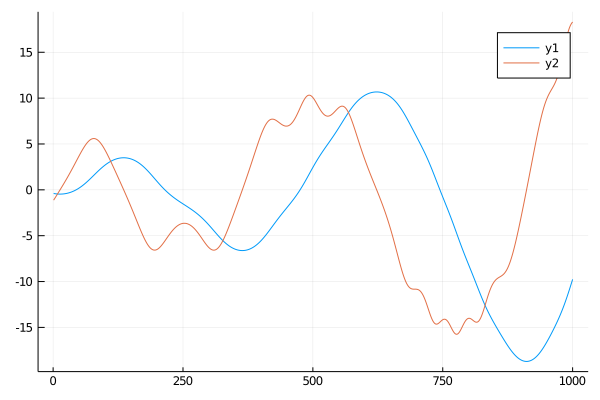

In [62]:
plot(X)

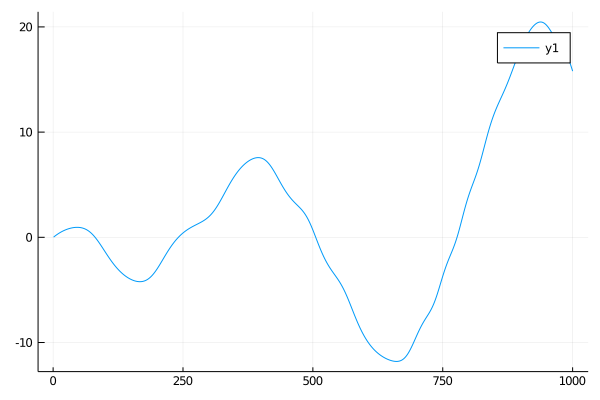

In [63]:
plot(A)